## Мандрикова Анастасия
## Отчет-2 к зачету

In [2]:
library(ggplot2)
library(ggpubr)
library(cowplot)
library(Rssa)
library(tseries)
library(forecast)
library(urca)
library(TTR)
library(dplyr)
library(tidyr)
library(gdata)

In [2]:
tser.align.center <- function(tser, len, def.val = NA) {
  len.diff <- len - length(tser)
  if (len.diff <= 0) {
    return(tser)
  }
  
  l.al <- len.diff %/% 2
  r.al <- len.diff - l.al
  c(rep(def.val, l.al), tser, rep(def.val, r.al))
}

tser.align.right <- function(tser, len, def.val = NA) {
  len.diff <- len - length(tser)
  if (len.diff <= 0) {
    return(tser)
  }
  
  c(rep(def.val, len.diff), tser)
}

tser.align.left <- function(tser, len, def.val = NA) {
  len.diff <- len - length(tser)
  if (len.diff <= 0) {
    return(tser)
  }
  
  c(tser, rep(def.val, len.diff))
}

tser.align <- function(tser, len, def.val = NA, type='center') {
  tser.len <- length(tser)
  len.diff <- len - tser.len
  if (len.diff <= 0) {
    return(tser)
  }
  
  switch(type, 'center'=tser.align.center, 'left'=tser.align.left, 'right'=tser.align.right)(tser, len, def.val)
}

tser.df.labelled.h <- function(lab, tser) {
  tser.len <- length(tser)
  as.data.frame(list(1:tser.len, as.numeric(tser), rep(lab, tser.len)), col.names = c("Index", "Values", "Labels"))
}

# for aligned series
tser.df.labelled <- function(tser.labs, ...) {
  Reduce(rbind, mapply(tser.df.labelled.h, tser.labs, list(...), SIMPLIFY = F, USE.NAMES = F))
}

tser.my.plot.h <- function(tser.df) {
  ggplot(data = tser.df) + geom_line(aes(x = Index, y = Values, col = Labels), alpha = 0.75)
}

tser.my.plot <- function(tser.orig, tser.trend, tser.season=NULL, plot.resid=T, plot.season=T, plot.reco=T,
                         component.labs=c("Trend", "Seasonal"), type.align='center', align.def.val=NA) {
  tser.trend.al <- tser.align(tser.trend, length(tser.orig))
  tser.resid <- tser.orig - tser.trend.al
  
  plot.list <- list(tser.my.plot.h(tser.df.labelled(c("Original", component.labs[1]), tser.orig, tser.trend.al)))

  if (!is.null(tser.season) && plot.season) {
    tser.season.al <- tser.align(tser.season, length(tser.orig))
    plot.list[[length(plot.list) + 1]] <- tser.my.plot.h(tser.df.labelled(c("Detrend", component.labs[2]), tser.resid, tser.season.al))
    tser.resid <- tser.resid - tser.season.al
  }
  
  if (!is.null(tser.season) && plot.reco) {
    tser.season.al <- tser.align(tser.season, length(tser.orig))
    plot.list[[length(plot.list) + 1]] <-  tser.my.plot.h(tser.df.labelled(c("Original", "Reconstructed"), tser.orig,
                                                                           tser.trend.al + tser.season.al))  
  }
  
  if (plot.resid) {
    plot.list[[length(plot.list) + 1]]<- tser.my.plot.h(tser.df.labelled(c("Residual"), tser.resid))
  }
  
  ggarrange(plotlist = plot.list, ncol = 1, nrow = length(plot.list), align = 'v')
}

# Рассмотрим модельные ряды и применение к ним ARIMA.

Warning message in window.default(x, ...):
"'start' value not changed"


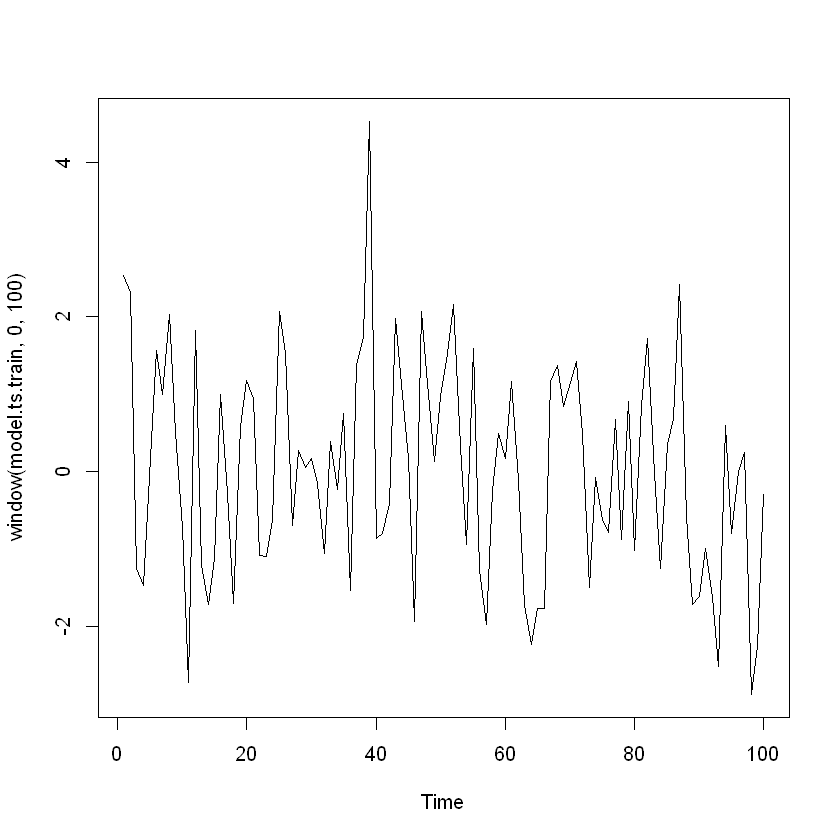

In [3]:
model.ts <- read.ts('ts8.txt', header = T)
model.ts.train <- window(model.ts, start = 1, end = 900)
model.ts.test <- window(model.ts, start = 901, 1000)
plot(window(model.ts.train, 0, 100))

In [4]:
adf.test(model.ts.train, alternative = "stationary")

Warning message in adf.test(model.ts.train, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  model.ts.train
Dickey-Fuller = -9.3396, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


Гипотеза о том, что есть единичный корень, не подтвердилась, нам не нужно дифференцировать ряд. Посмотрим на графики автокорреляций.

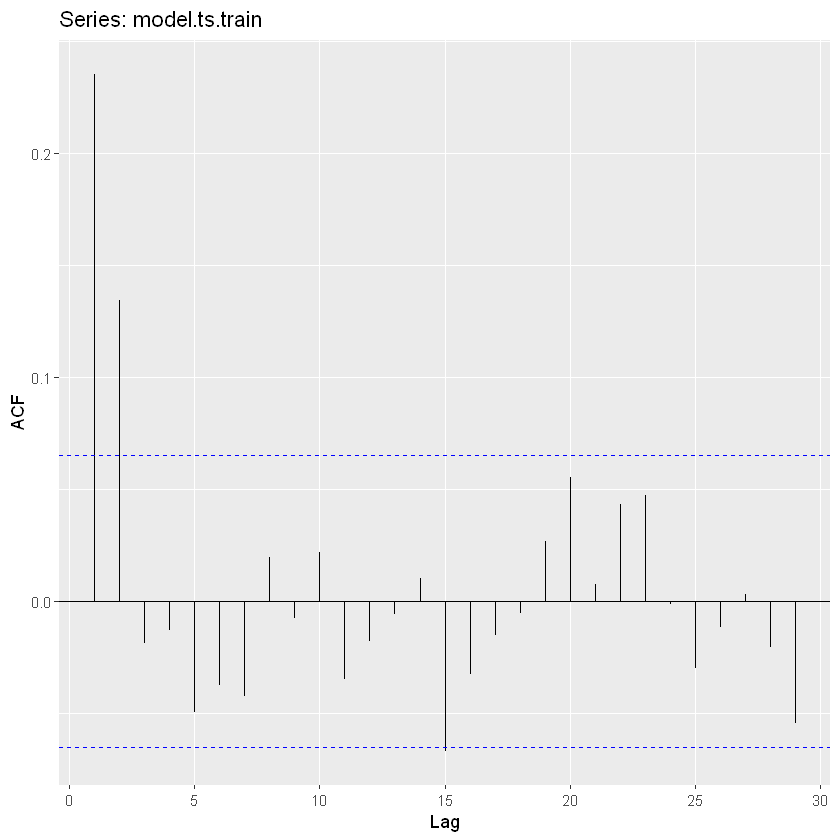

In [5]:
ggAcf(model.ts.train)

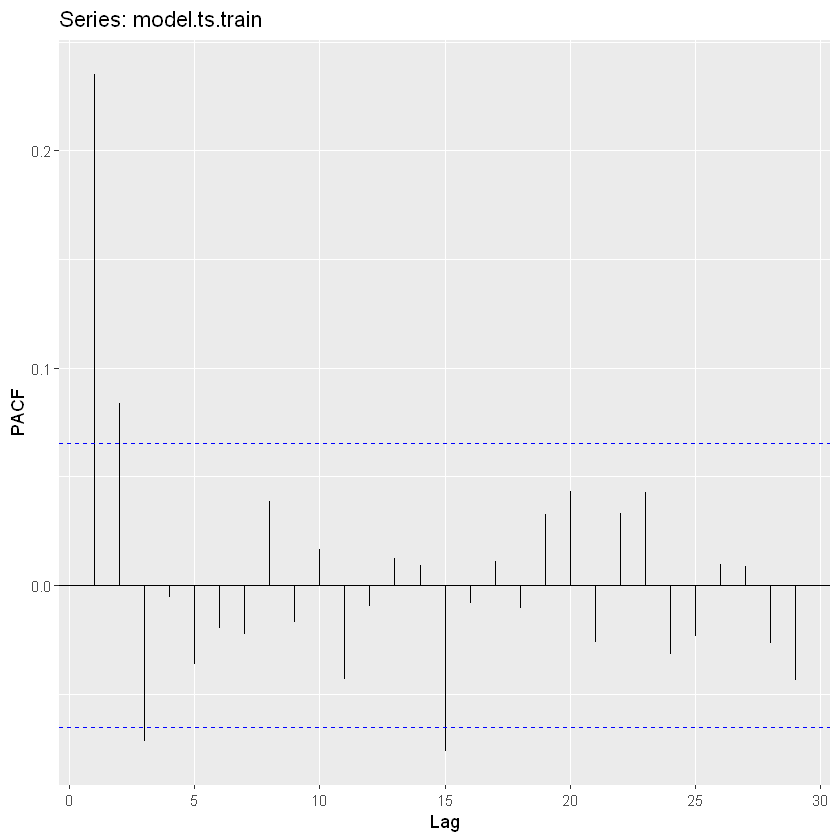

In [6]:
ggPacf(model.ts.train)

На глаз модель смешанная, посмотрим что даст auto.arima.

In [7]:
auto.arima(model.ts.train, stepwise = F, stationary = T, seasonal = F, 
           allowmean = F, ic = "aicc", trace = T, max.order = 4)


 Fitting models using approximations to speed things up...

 ARIMA(0,0,0) with zero mean     : 3190.191
 ARIMA(0,0,1) with zero mean     : 3150.251
 ARIMA(0,0,2) with zero mean     : 3131.842
 ARIMA(0,0,3) with zero mean     : 3133.745
 ARIMA(0,0,4) with zero mean     : 3135.689
 ARIMA(1,0,0) with zero mean     : 3137.779
 ARIMA(1,0,1) with zero mean     : 3135.267
 ARIMA(1,0,2) with zero mean     : 3132.079
 ARIMA(1,0,3) with zero mean     : 3132.57
 ARIMA(2,0,0) with zero mean     : 3132.58
 ARIMA(2,0,1) with zero mean     : 3129.667
 ARIMA(2,0,2) with zero mean     : 3131.126
 ARIMA(3,0,0) with zero mean     : 3128.932
 ARIMA(3,0,1) with zero mean     : 3130.382
 ARIMA(4,0,0) with zero mean     : 3131.094

 Now re-fitting the best model(s) without approximations...




 Best model: ARIMA(3,0,0) with zero mean     



Series: model.ts.train 
ARIMA(3,0,0) with zero mean 

Coefficients:
         ar1     ar2      ar3
      0.2237  0.1015  -0.0716
s.e.  0.0333  0.0339   0.0334

sigma^2 estimated as 1.891:  log likelihood=-1562.38
AIC=3132.76   AICc=3132.81   BIC=3151.97

Третий коэффицент незначим, уменьшим максимальное число параметров модели.

In [8]:
auto.arima(model.ts.train, stepwise = F, stationary = T, seasonal = F, 
           allowmean = F, ic = "aicc", trace = T, max.order = 2)


 Fitting models using approximations to speed things up...

 ARIMA(0,0,0) with zero mean     : 3190.191
 ARIMA(0,0,1) with zero mean     : 3150.251
 ARIMA(0,0,2) with zero mean     : 3131.842
 ARIMA(1,0,0) with zero mean     : 3137.779
 ARIMA(1,0,1) with zero mean     : 3135.267
 ARIMA(2,0,0) with zero mean     : 3132.58

 Now re-fitting the best model(s) without approximations...




 Best model: ARIMA(0,0,2) with zero mean     



Series: model.ts.train 
ARIMA(0,0,2) with zero mean 

Coefficients:
         ma1     ma2
      0.2251  0.1513
s.e.  0.0331  0.0327

sigma^2 estimated as 1.891:  log likelihood=-1562.74
AIC=3131.48   AICc=3131.5   BIC=3145.88

$MA(2)$ это реальная модель ряда, её же предлагает функция, если ограничить максимальное число параметров двумя.

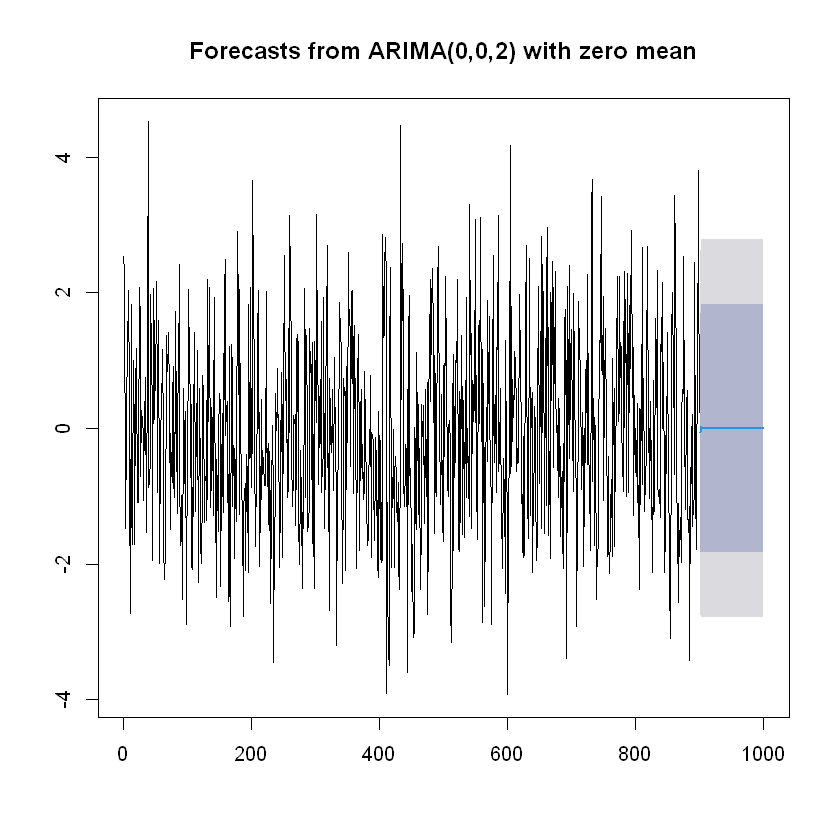

In [9]:
model.arima <- auto.arima(model.ts.train, stepwise = F, stationary = T, seasonal = F, allowmean = F, 
                          ic = "aicc", trace = F, max.order = 2)
model.forecast <- forecast(model.arima, h = 100)
plot(model.forecast)


	Ljung-Box test

data:  Residuals from ARIMA(0,0,2) with zero mean
Q* = 5.1441, df = 8, p-value = 0.7421

Model df: 2.   Total lags used: 10



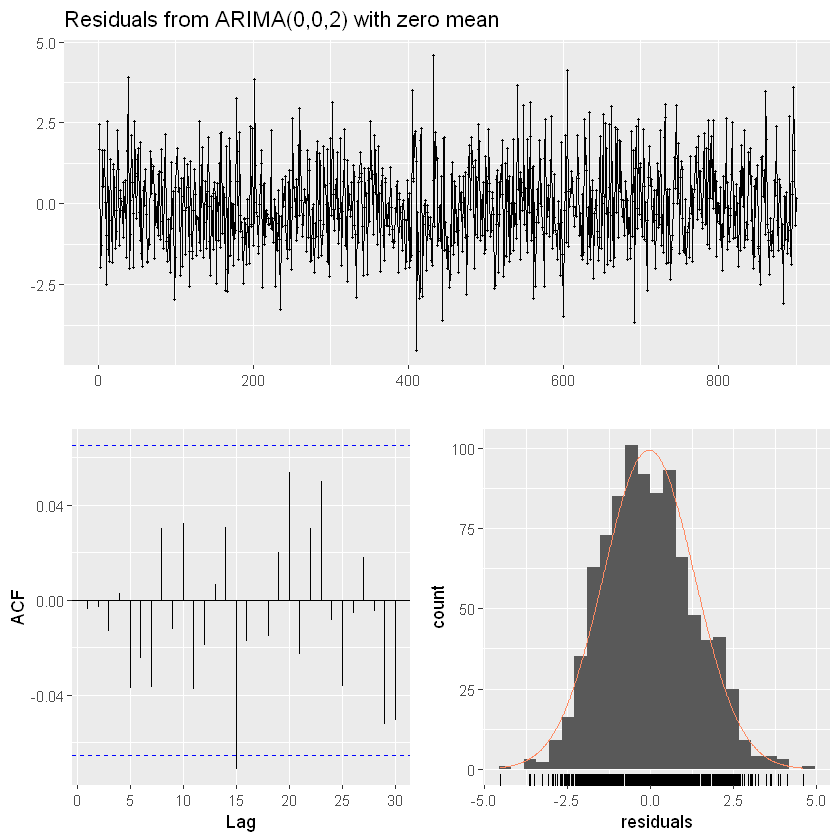

In [10]:
checkresiduals(model.arima)

По графикам видим, что в качестве остатка получили что-то похожее на белый шум.   
Ошибка на тестовых данных:

In [11]:
mse <- mean((model.ts.test - model.forecast$mean) ^ 2)
mse

[1] 2.141163

# Применим к этому же ряду экспоненциальное сглаживание

In [12]:
ets <- ets(model.ts.train, ic = "aicc", opt.crit = "lik")
ets

ETS(A,N,N) 

Call:
 ets(y = model.ts.train, opt.crit = "lik", ic = "aicc") 

  Smoothing parameters:
    alpha = 1e-04 

  Initial states:
    l = -0.0662 

  sigma:  1.4224

     AIC     AICc      BIC 
6760.404 6760.431 6774.811 

Модель $ETS(A, N, N)$ с аддитивными ошибками, без тренда и сезонности. Что похоже на правду, так как мы рассматриваем стационарный ряд. Делаем предсказание.

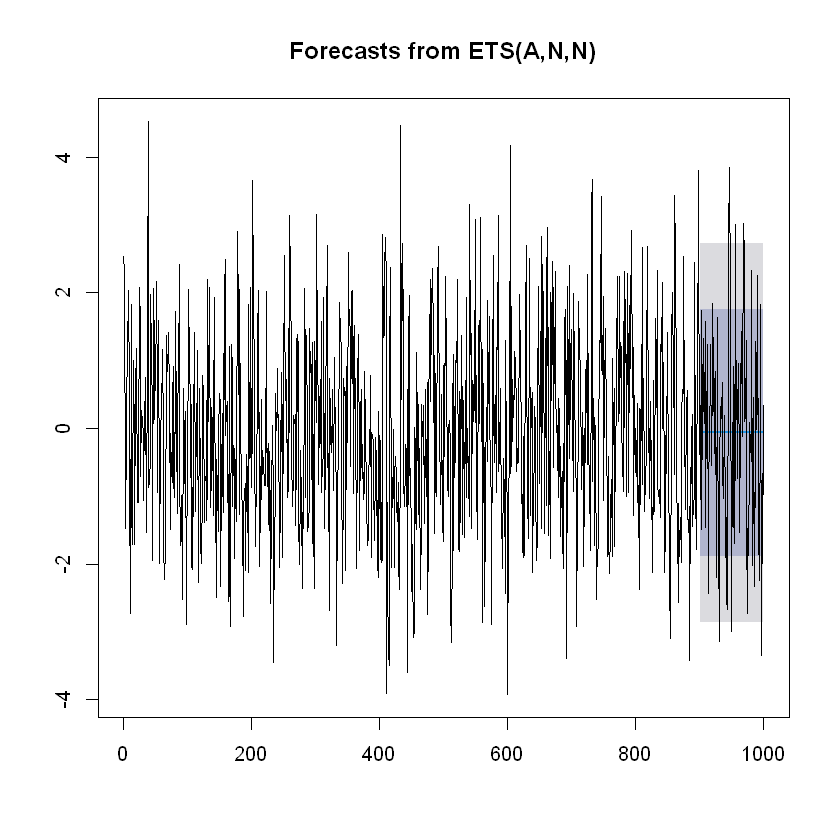

In [13]:
ets.forecast <- forecast(ets, h = 100)
plot(ets.forecast)
lines(model.ts)


	Ljung-Box test

data:  Residuals from ETS(A,N,N)
Q* = 72.744, df = 8, p-value = 1.394e-12

Model df: 2.   Total lags used: 10



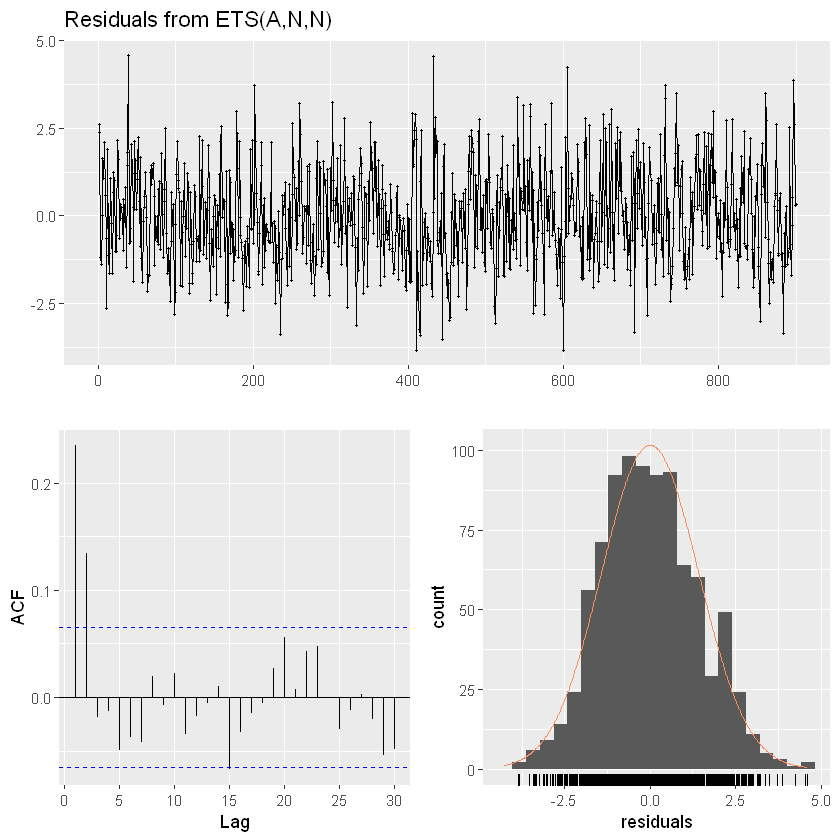

In [14]:
checkresiduals(ets)

Для данной модели остатки уже не выглядят как случайные.   
Ошибка на тесте:

In [15]:
ets.mse <- mean((model.ts.test - ets.forecast$mean) ^ 2)
ets.mse

[1] 2.138668

По ошибкам модели ведут себя одинаково. 

# Рассмотрим второй модельный ряд. Начнем с ARIMA

Warning message in window.default(x, ...):
"'start' value not changed"


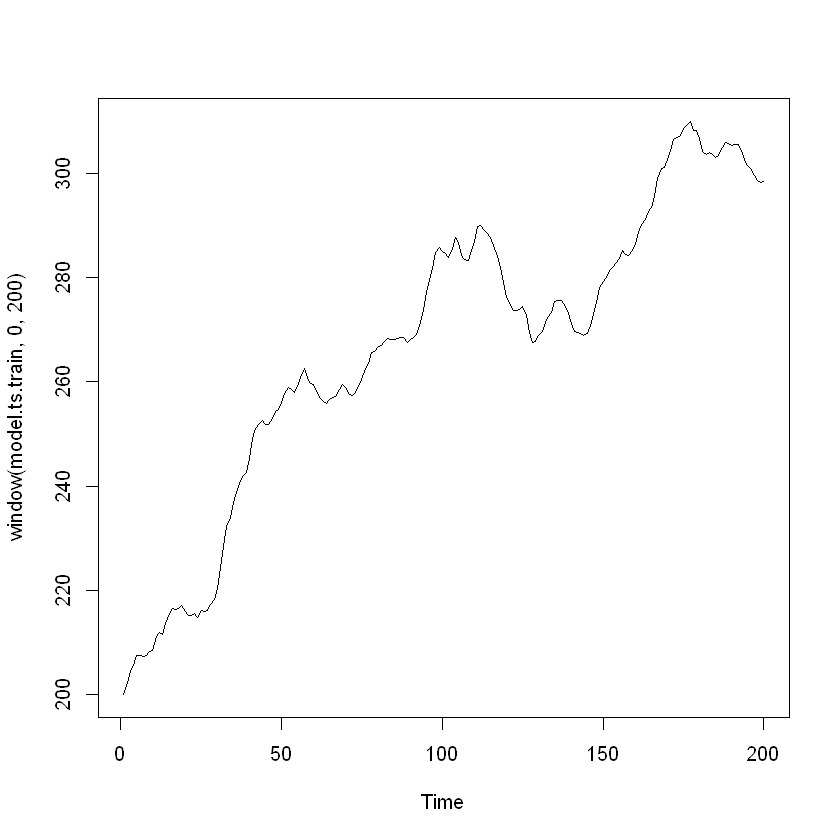

In [16]:
model.ts <- read.ts('ts3.txt', header = T)
model.ts.train <- window(model.ts, start = 1, end = 900)
model.ts.test <- window(model.ts, start = 901, 1001)
plot(window(model.ts.train, 0, 200))

Видим, что ряд явно надо дифференцировать.

In [17]:
ndiffs(model.ts.train, test = "adf")

[1] 1

Достаточно будет продифференцировать ряд один раз. Продифференцируем и проверим, стал ли ряд стационарным.

In [18]:
df <- diff(model.ts.train)

In [19]:
adf.test(df, alternative = "stationary")

Warning message in adf.test(df, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  df
Dickey-Fuller = -7.8045, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


Да, гипотеза о наличии единичного корня не подтвердилась, ряд стационарный. 

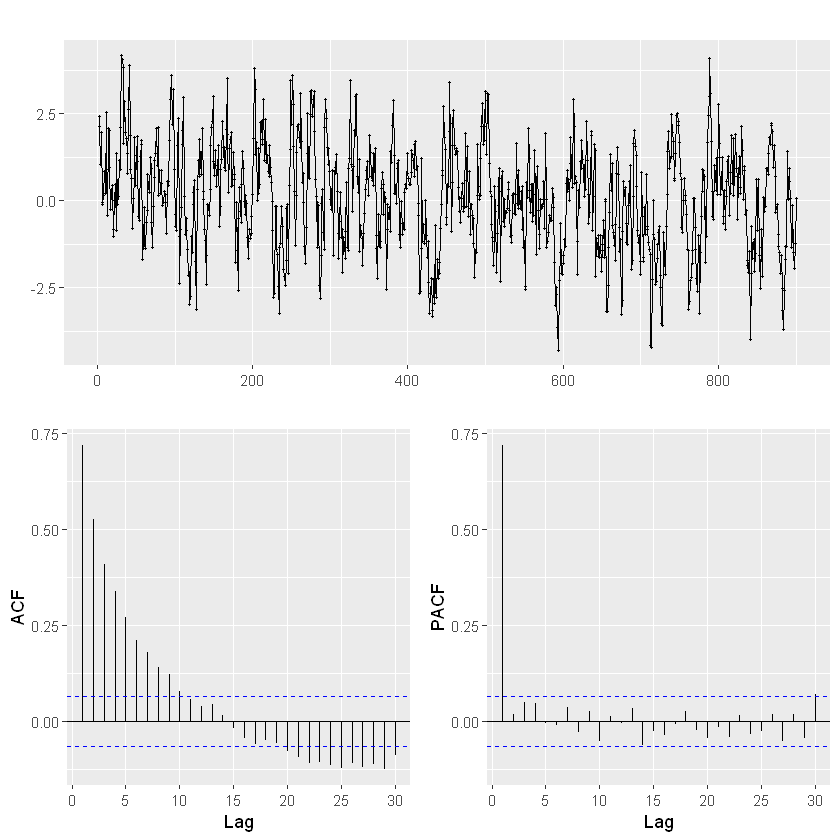

In [20]:
ggtsdisplay(df)

ACF сначала медленно убывает, а затем по модулю чуть-чуть растет. На графике PACF только первая компонента не нулевая. Если бы ACF вела себя как экспонента, было бы похоже на модель $AR(1)$. Так как это после дифференцирования, то изначальный ряд из модели $ARIMA(1, 1, 0)$. Это реальная модель ряда, а что дает в результате auto.arima?

In [21]:
arima <- auto.arima(model.ts.train, d= 1, ic = "aicc", stepwise = F, trace = F)
arima

Series: model.ts.train 
ARIMA(2,1,1) 

Coefficients:
          ar1     ar2     ma1
      -0.2351  0.6832  0.9668
s.e.   0.0538  0.0451  0.0428

sigma^2 estimated as 1.089:  log likelihood=-1312.78
AIC=2633.55   AICc=2633.6   BIC=2652.76

Все коэффициенты значимы.

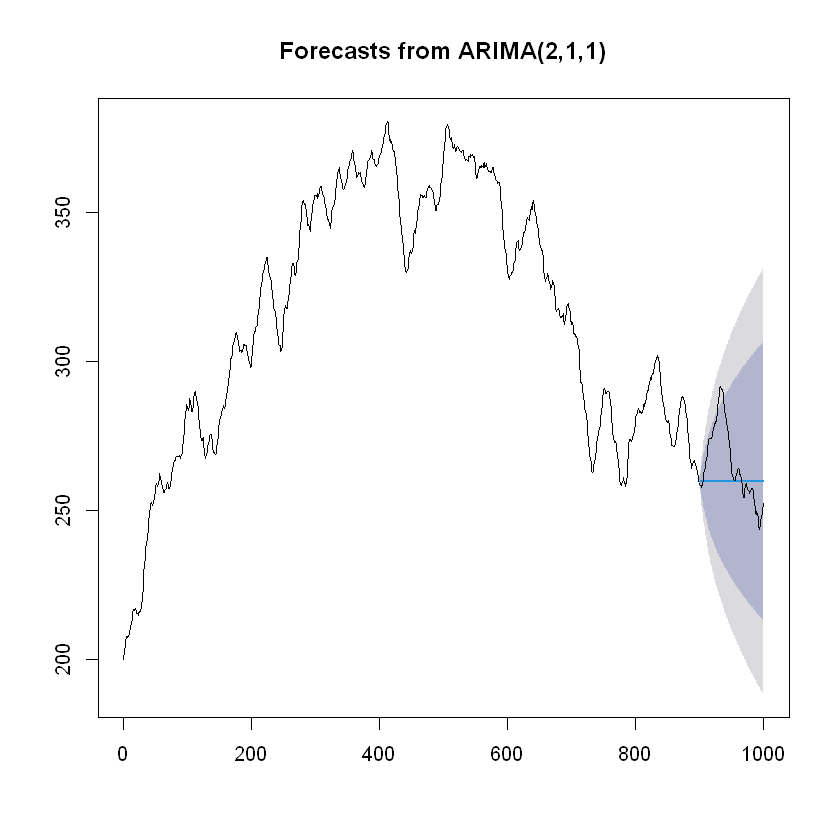

In [22]:
arima.forecast1 <- forecast(arima, h = 101)
plot(arima.forecast1)
lines(model.ts.test)

Посмотрим на остатки продифференцированного ряда.


	Ljung-Box test

data:  Residuals from ARIMA(2,1,1)
Q* = 8.4374, df = 7, p-value = 0.2956

Model df: 3.   Total lags used: 10



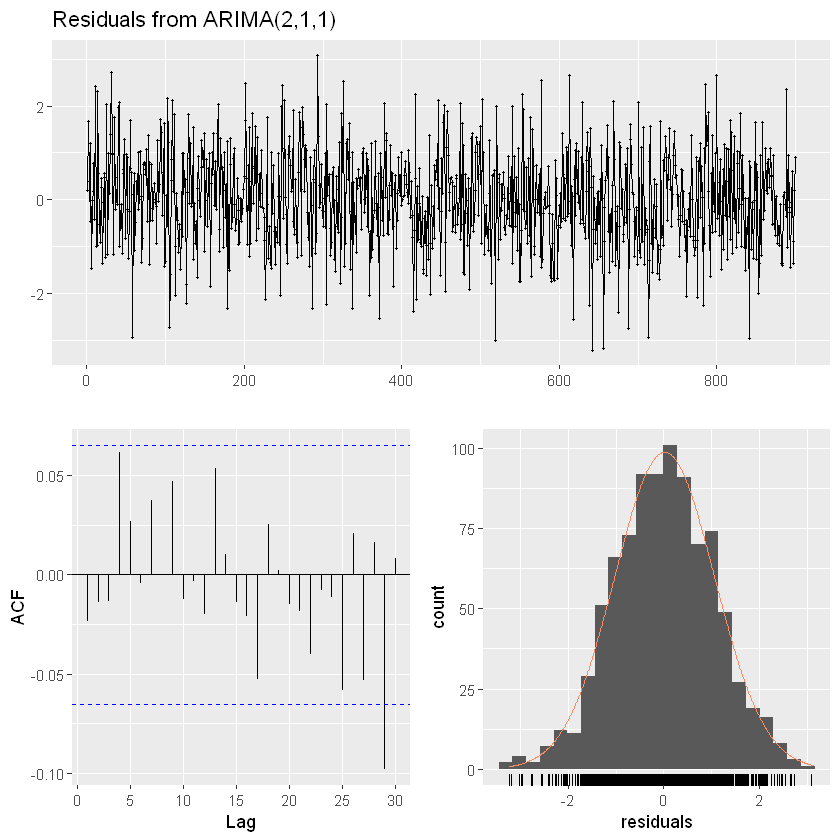

In [23]:
checkresiduals(arima)

По графику похоже на белый шум и гипотеза о случайности наблюдений не отвергается. 

Посчитаем ошибку для продиффиренцированного ряда.

In [24]:
arima.mse <- mean(diff((model.ts.test - arima.forecast1$mean)) ^ 2)
arima.mse

[1] 2.000261

Теперь посмотрим на результаты с использованием реальной модели. По кол-ву параметров она меньше, поэтому приоритетнее для выбора.

In [25]:
arima <- auto.arima(model.ts.train, d= 1, max.p = 1, start.p = 1, max.q = 0, ic = "aicc", stepwise = F, trace = F)
arima

Series: model.ts.train 
ARIMA(1,1,0) 

Coefficients:
         ar1
      0.7208
s.e.  0.0231

sigma^2 estimated as 1.089:  log likelihood=-1313.72
AIC=2631.45   AICc=2631.46   BIC=2641.05

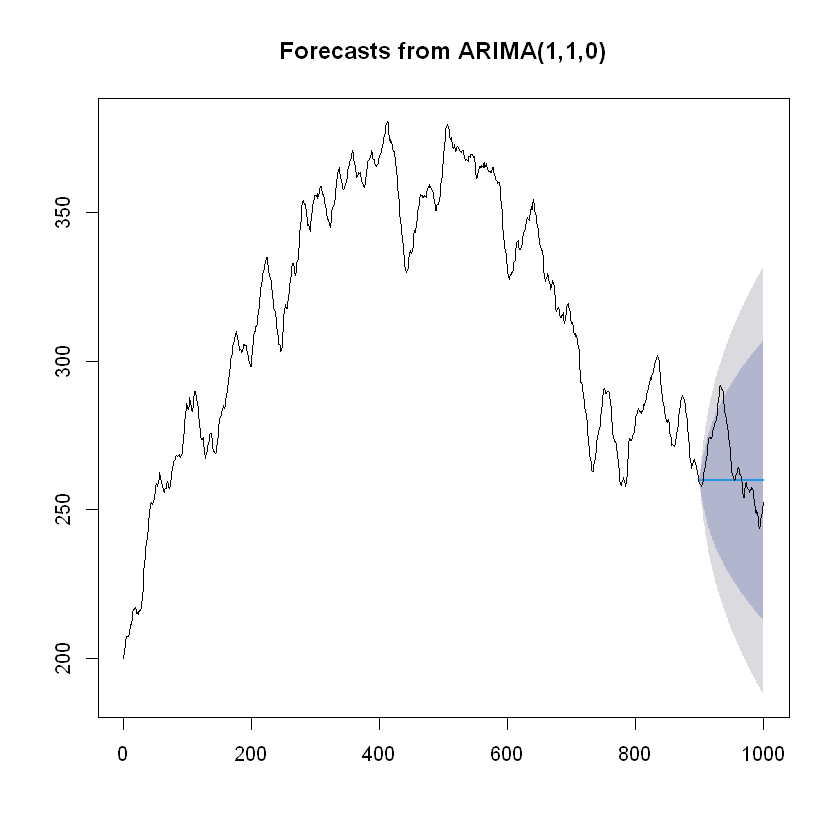

In [26]:
arima.forecast <- forecast(arima, h = 101)
plot(arima.forecast)
lines(model.ts.test)


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)
Q* = 9.8797, df = 9, p-value = 0.3603

Model df: 1.   Total lags used: 10



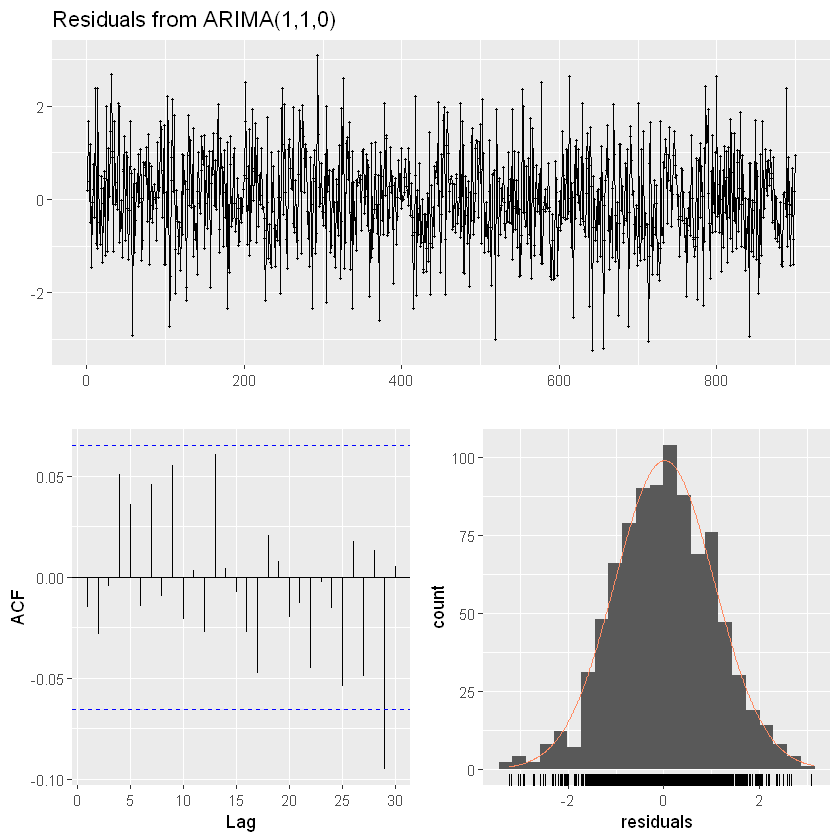

In [27]:
checkresiduals(arima)

Графики остатком очень похожи на результаты предыдущей модели.

In [28]:
arima.mse <- mean(diff((model.ts.test - arima.forecast$mean)) ^ 2)
arima.mse

[1] 2.000102

Ошибки у моделей в одних пределах.

# На втором модельном ряду перейдем к экспоненциальному сглаживанию.

In [29]:
ets <- ets(model.ts.train, ic = "aicc", opt.crit = "lik")
ets

ETS(A,Ad,N) 

Call:
 ets(y = model.ts.train, opt.crit = "lik", ic = "aicc") 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.8725 
    phi   = 0.8 

  Initial states:
    l = 200.3088 
    b = 1.1789 

  sigma:  1.0504

     AIC     AICc      BIC 
6217.572 6217.666 6246.386 

Модель $ETS(A, Ad, N)$ с аддитивными ошибками, монотонным треном без сезонности. И снова похоже на правду (после дифференцирования ряд был стационарным).

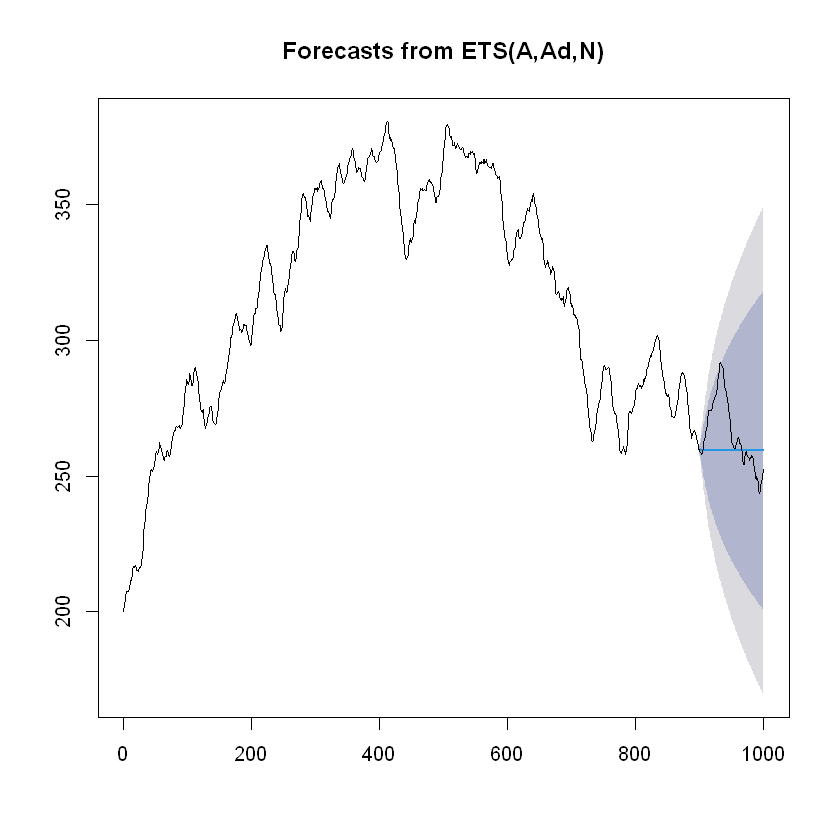

In [30]:
ets.forecast <- forecast(ets, h = 101)
plot(ets.forecast)
lines(model.ts)


	Ljung-Box test

data:  Residuals from ETS(A,Ad,N)
Q* = 14.094, df = 5, p-value = 0.01502

Model df: 5.   Total lags used: 10



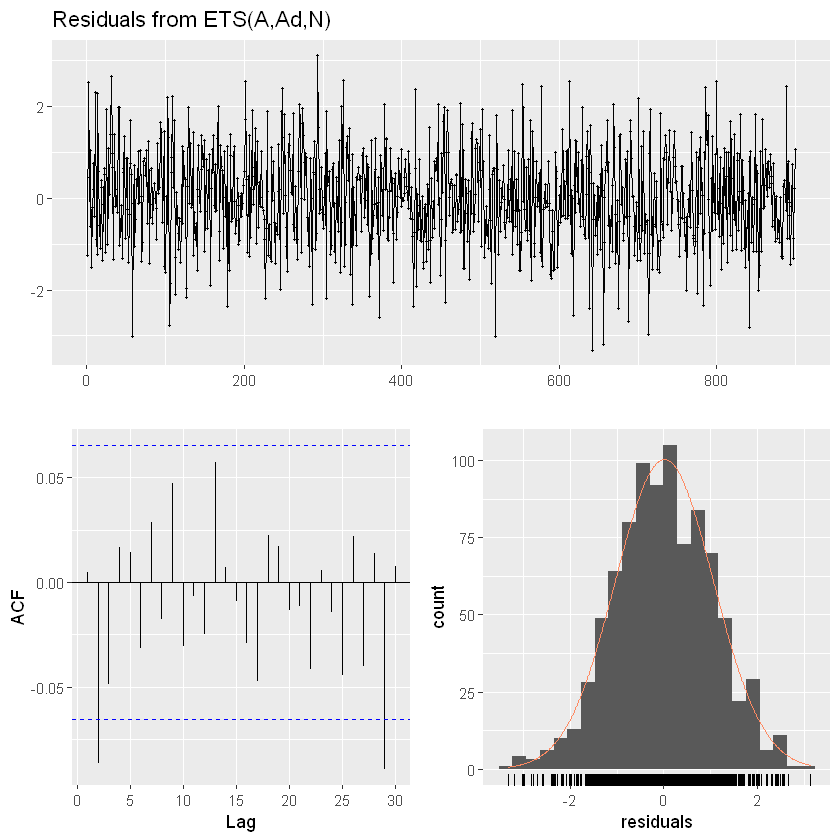

In [31]:
checkresiduals(ets)

Судя по автокорреляциям остатки не случайны. Хотя график также похож на белый шум.

In [32]:
ets.mse <- mean(diff((model.ts.test - ets.forecast$mean)) ^ 2)
ets.mse

[1] 2.002791

Ошибка на тестовом наборе сравнима с моделями arima.

# Перейдем к реальному ряду. 
Прогноз будем делать с помощью ARIMA, SSA и ETS. Начнем с ARIMA
## ARIMA

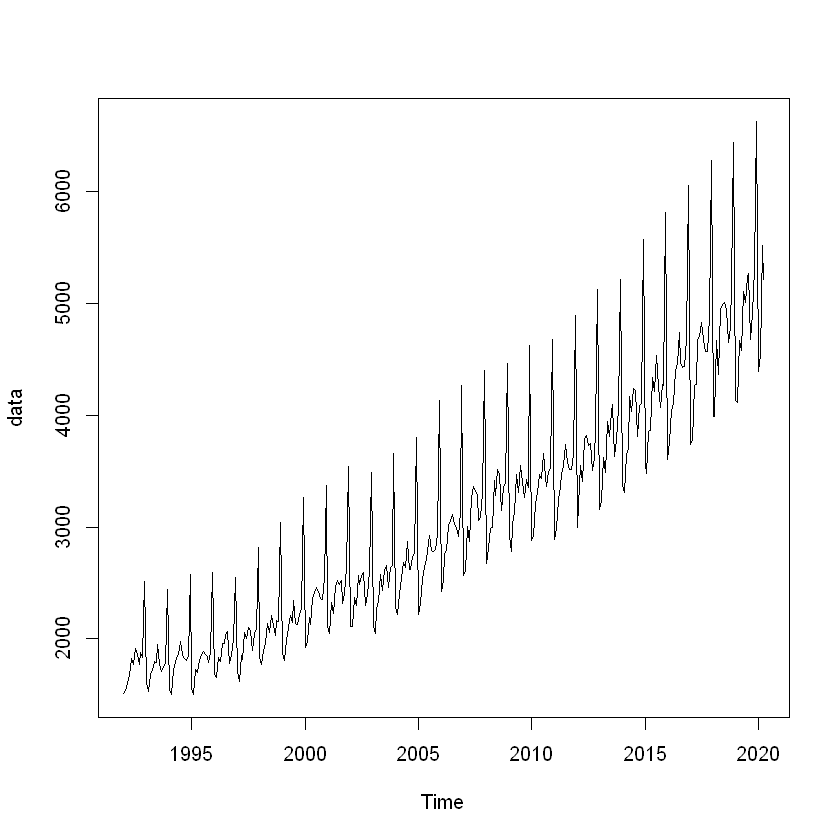

In [33]:
data <- read.table('series.csv', sep=',', header=T, row.names = 1)  
data <- ts(data, start = c(1992, 1), end = c(2020, 4), frequency = 12)
plot(data)

На самом деле из рассматриваемого ряда уже удалено некоторое кол-во последних точек, так как там наблюдалась неоднородность, предсказания справлялись бы не очень хорошо как минимум.

In [34]:
model.ts.train <- window(data, start = c(1992, 1), end = c(2019, 4))
model.ts.test <- window(data, start = c(2019, 5), end = c(2020, 4))

Ряд не стационарный, подберем параметр для диффернцирования.

In [35]:
ndiffs(model.ts.train)

[1] 1

Подбираем параметр для сезонной составляющей.

In [36]:
nsdiffs(model.ts.train)

[1] 1

Сезонно продифференцированный ряд

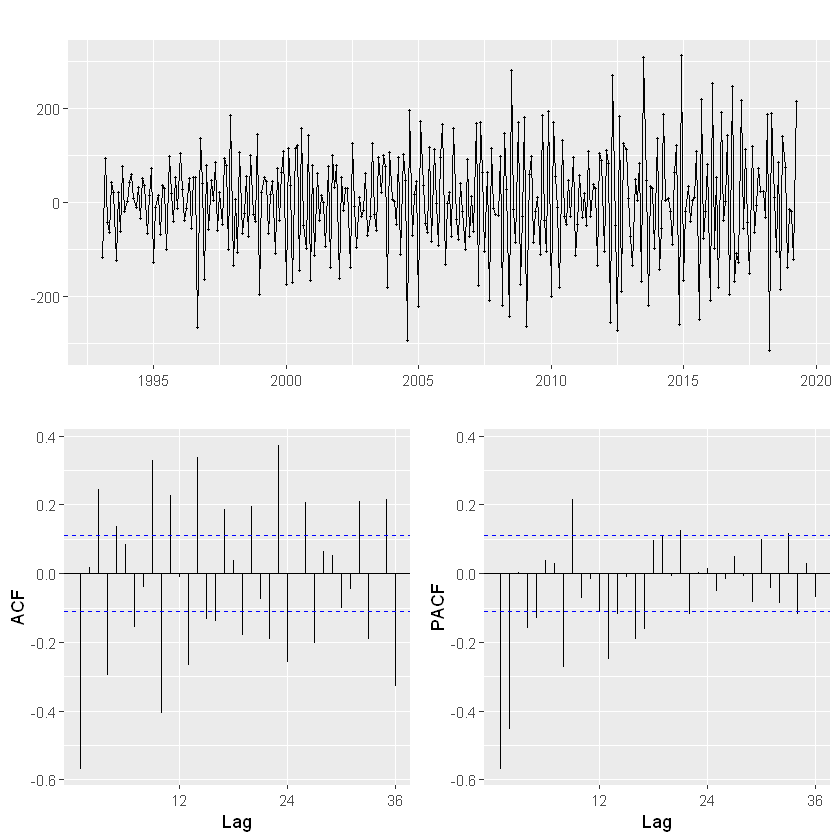

In [37]:
ggtsdisplay(diff(diff(model.ts.train), lag = 12))

Кажется, что дисперсия в како-то момент начинает увеличиваться. Пока не будем с этим бороться, просто подберем модель автоматически.

In [38]:
arima <- auto.arima(model.ts.train, d = 1, D = 1, ic = "aicc", stepwise = F, trace = F, max.order = 5)
arima

Series: model.ts.train 
ARIMA(2,1,2)(0,1,1)[12] 

Coefficients:
          ar1      ar2     ma1      ma2     sma1
      -1.1468  -0.4216  0.2471  -0.4993  -0.3035
s.e.   0.0789   0.0691  0.0836   0.0821   0.0687

sigma^2 estimated as 6287:  log likelihood=-1823.23
AIC=3658.47   AICc=3658.74   BIC=3680.98

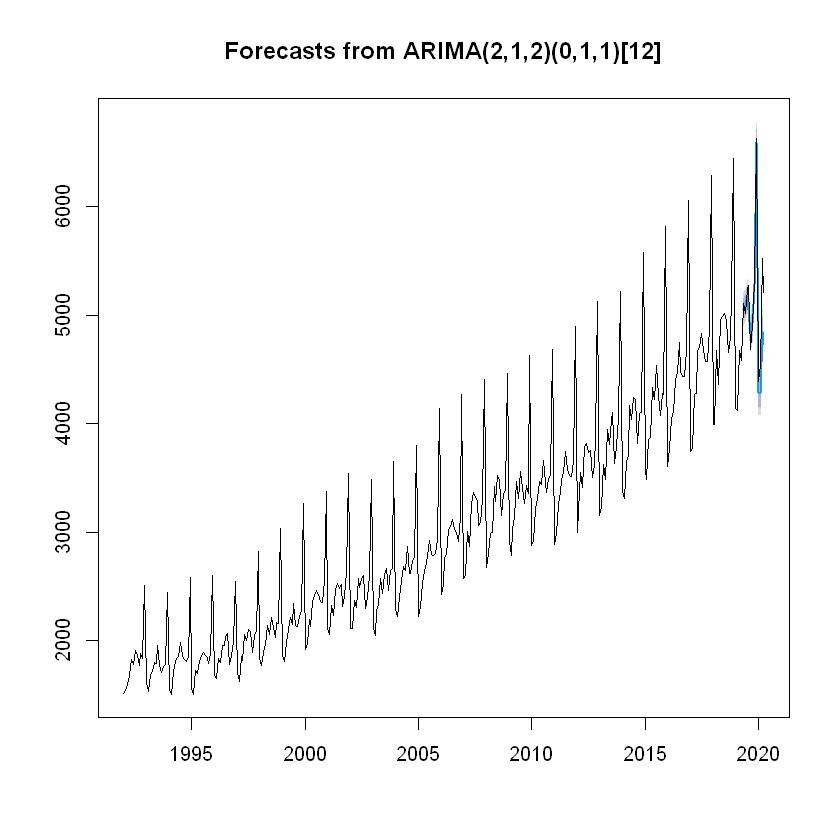

In [39]:
arima.forecast <- forecast(arima, h = 12)
plot(arima.forecast)
lines(data)


	Ljung-Box test

data:  Residuals from ARIMA(2,1,2)(0,1,1)[12]
Q* = 128.74, df = 19, p-value < 2.2e-16

Model df: 5.   Total lags used: 24



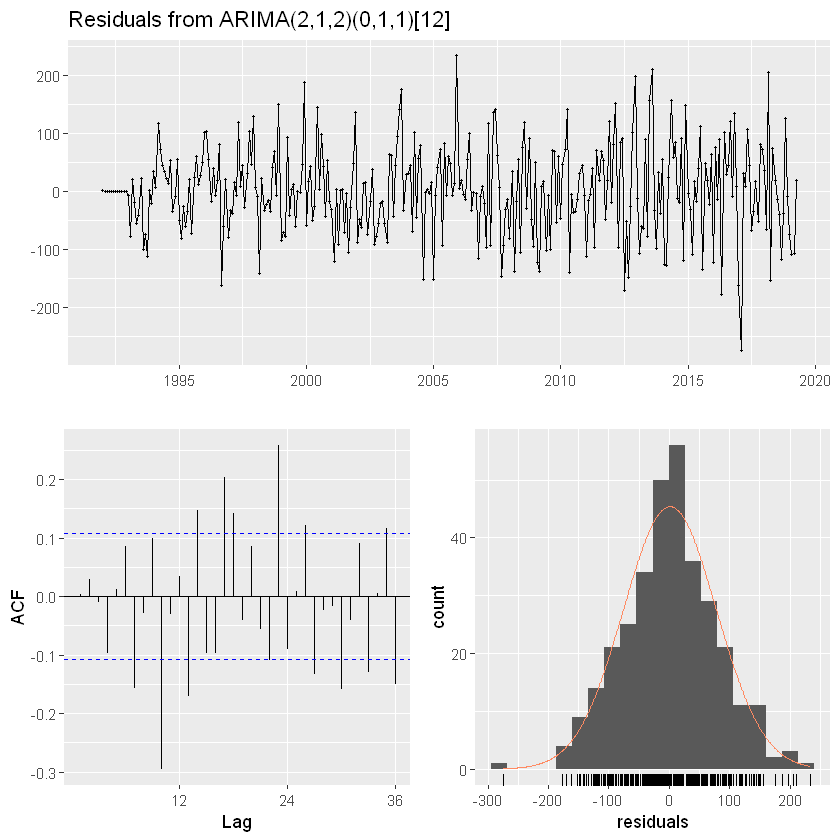

In [40]:
checkresiduals(arima)

Остатки не похожи на белый шум ни по их графику ни по графику автокореляций и соотвествующая гипотзеа отвергается.

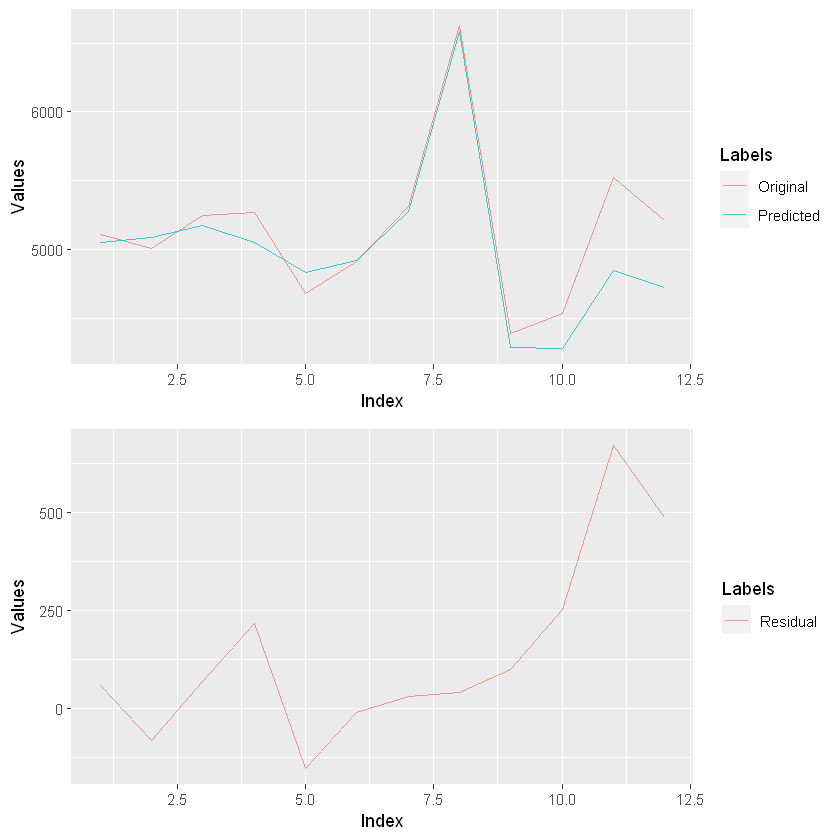

In [41]:
tser.my.plot(model.ts.test, arima.forecast$mean, component.labs = c("Predicted"))

Последние $4$ точки очень выбиваются по предсказаниям. Не исключено, что это потому что они взяты из последнего $2020$ года, последние наблюдения которого мы удалили. 

In [42]:
arima.mse <- mean((model.ts.test - arima.forecast$mean) ^ 2)
arima.mse

[1] 70698.16

Посмотрим изменится ли ошибка после применения преобразования Бокса-Кокса.

In [43]:
lambda <- BoxCox.lambda(model.ts.train)
lambda

[1] 0.1016157

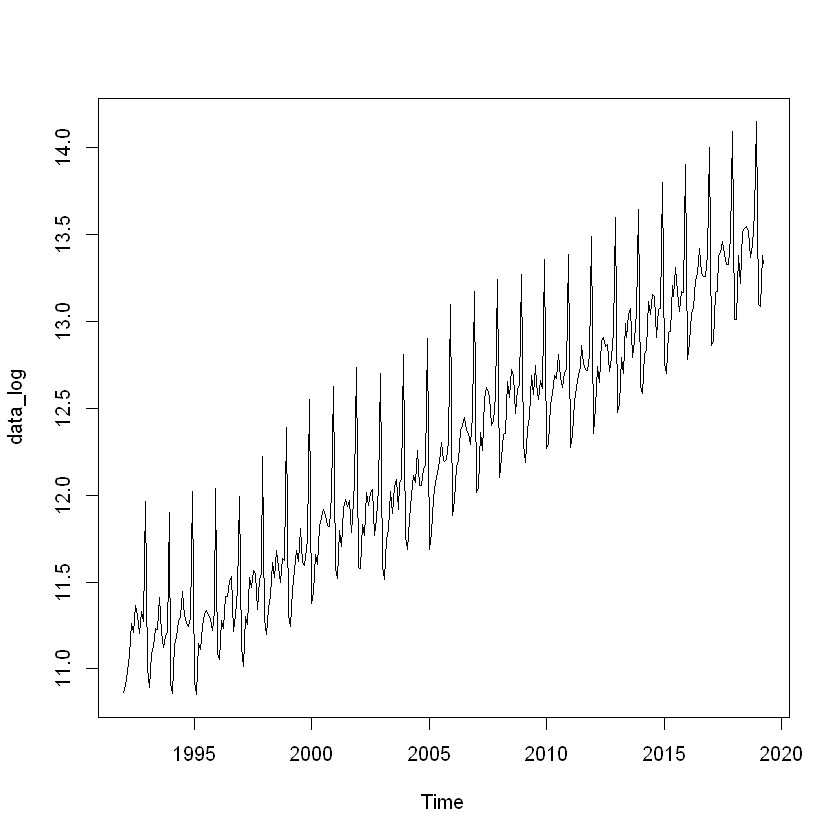

In [44]:
data_log <- BoxCox(model.ts.train, lambda)
plot(data_log)

In [45]:
ndiffs(data_log, test = "adf")

[1] 0

In [46]:
nsdiffs(data_log)

[1] 1

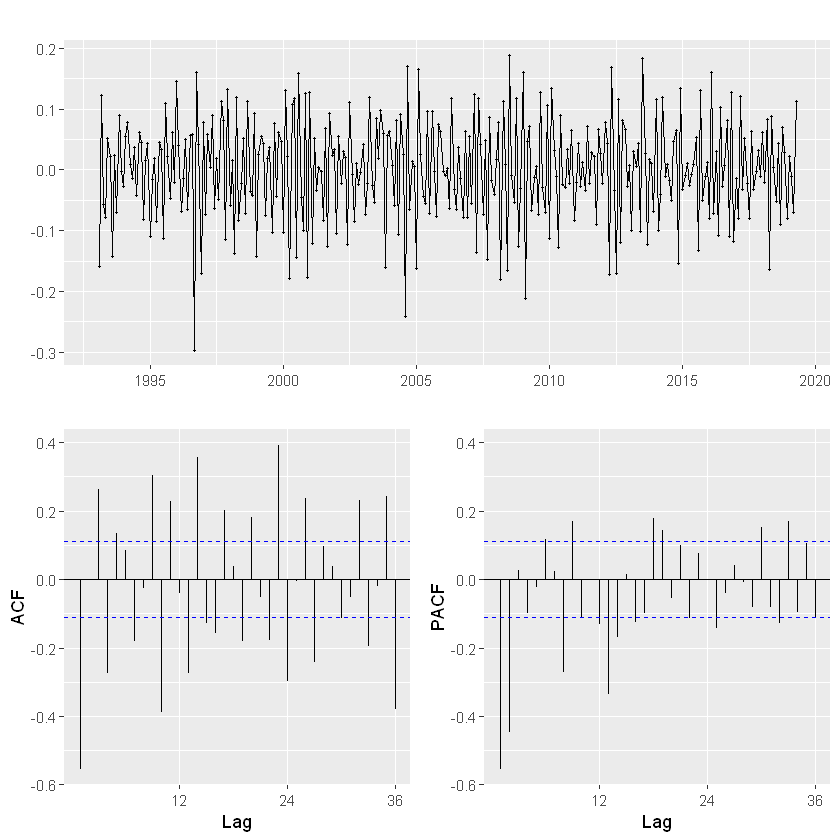

In [47]:
ggtsdisplay(diff(diff(data_log), 12))

Преобразование помогло побороть проблему с возрастающей дисперсией. Какие теперь результаты даст auto.arima?

In [48]:
log.arima <- auto.arima(data_log, d = 0, D = 1, stepwise = F, seasonal = T, ic = "aicc", max.order = 5)
log.arima

Series: data_log 
ARIMA(3,0,0)(0,1,1)[12] with drift 

Coefficients:
         ar1     ar2     ar3     sma1   drift
      0.0730  0.3135  0.4783  -0.7941  0.0073
s.e.  0.0501  0.0472  0.0503   0.0554  0.0004

sigma^2 estimated as 0.00291:  log likelihood=470.8
AIC=-929.59   AICc=-929.32   BIC=-907.06


	Ljung-Box test

data:  Residuals from ARIMA(3,0,0)(0,1,1)[12] with drift
Q* = 119.7, df = 19, p-value < 2.2e-16

Model df: 5.   Total lags used: 24



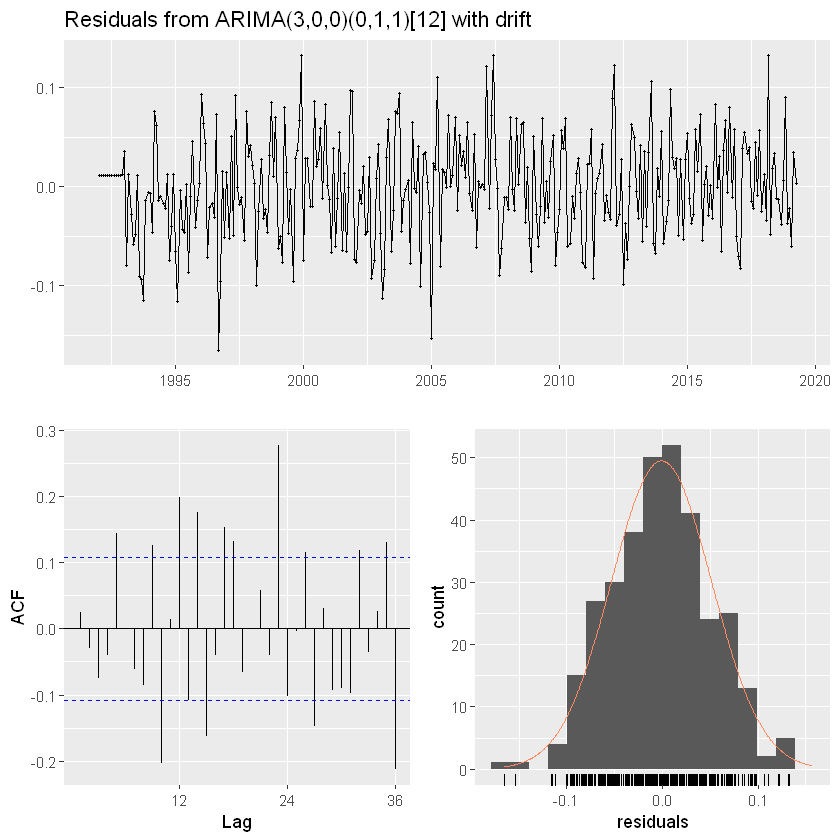

In [49]:
checkresiduals(log.arima)

Остатки другие, но опять не похожи на белый шум.

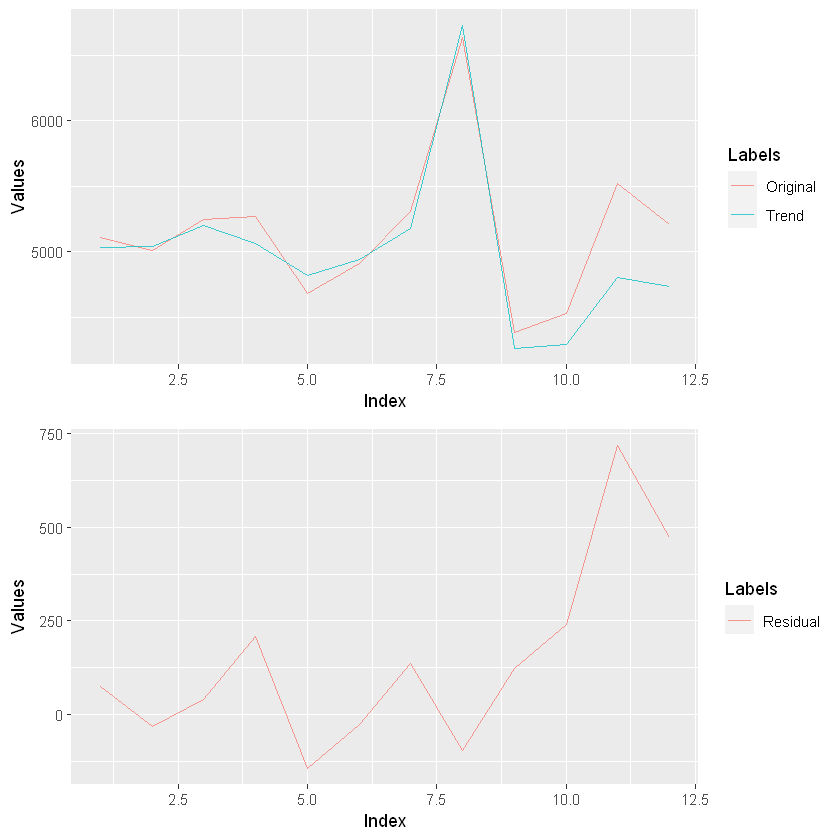

In [50]:
log.forecast <- forecast(log.arima, h = 12)
log.forecast.inv <- InvBoxCox(log.forecast$mean, lambda = lambda)
tser.my.plot(model.ts.test, log.forecast.inv)

In [51]:
log.arima.mse <- mean((model.ts.test - log.forecast.inv) ^ 2)
log.arima.mse

[1] 76307.49

А вот ошибка даже возрасла.

# ETS

In [52]:
ets <- ets(model.ts.train, ic = "aicc", opt.crit = "lik")
ets

ETS(M,A,M) 

Call:
 ets(y = model.ts.train, opt.crit = "lik", ic = "aicc") 

  Smoothing parameters:
    alpha = 0.2093 
    beta  = 0.0117 
    gamma = 1e-04 

  Initial states:
    l = 1808.9589 
    b = 1.107 
    s = 1.3738 1.0219 0.9884 0.9626 1.0176 1.0485
           1.0044 1.0168 0.9325 0.9357 0.8462 0.8517

  sigma:  0.0253

     AIC     AICc      BIC 
4719.063 4721.037 4783.544 

Модель $ETS(M, A, M)$ с мультрипликативными ошибками, монотонным трендом и мультипликативной сезонностью. Да, при рассмотрении ряда мы уже делали замечание, что его модель точно не аддитивная. 

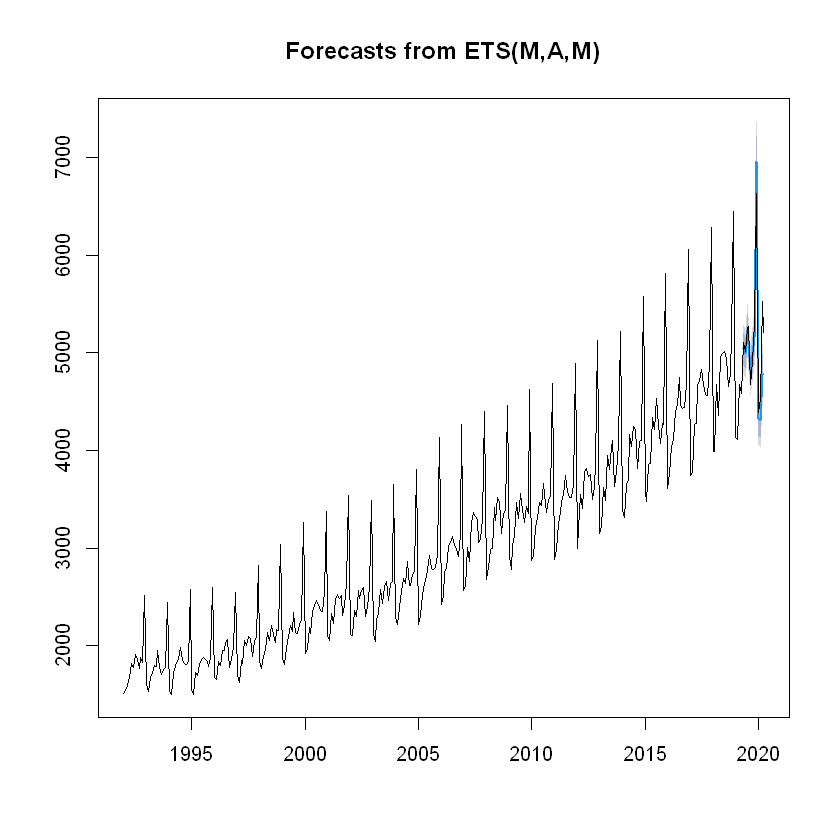

In [53]:
ets.forecast <- forecast(ets, h = 12)
plot(ets.forecast)
lines(data)


	Ljung-Box test

data:  Residuals from ETS(M,A,M)
Q* = 284.95, df = 8, p-value < 2.2e-16

Model df: 16.   Total lags used: 24



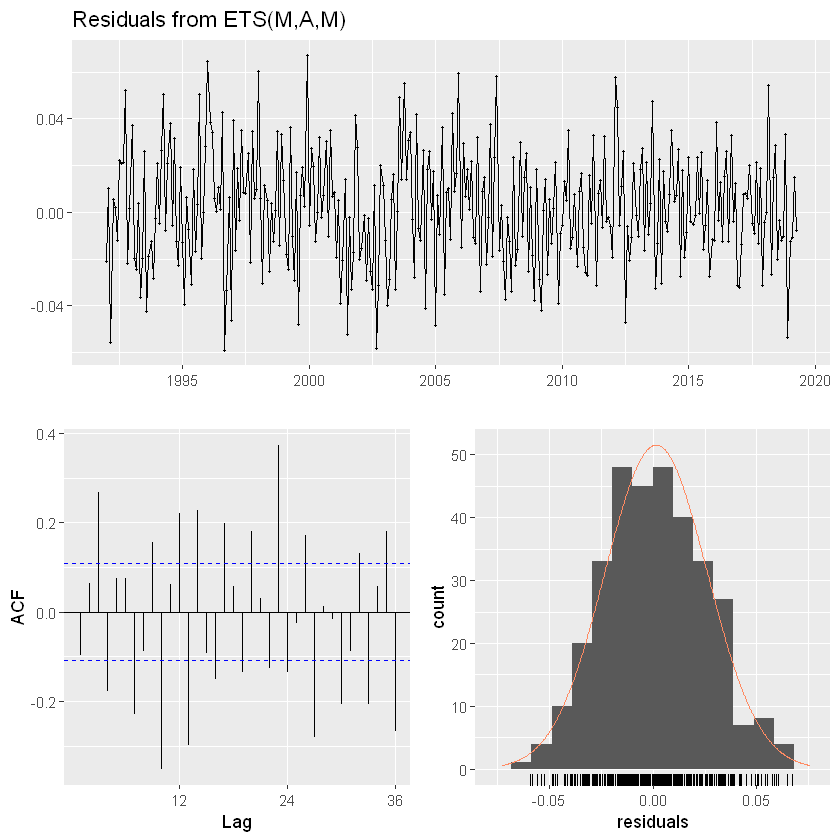

In [54]:
checkresiduals(ets)

Снова исходя из вида остатков модель не идеальна. 

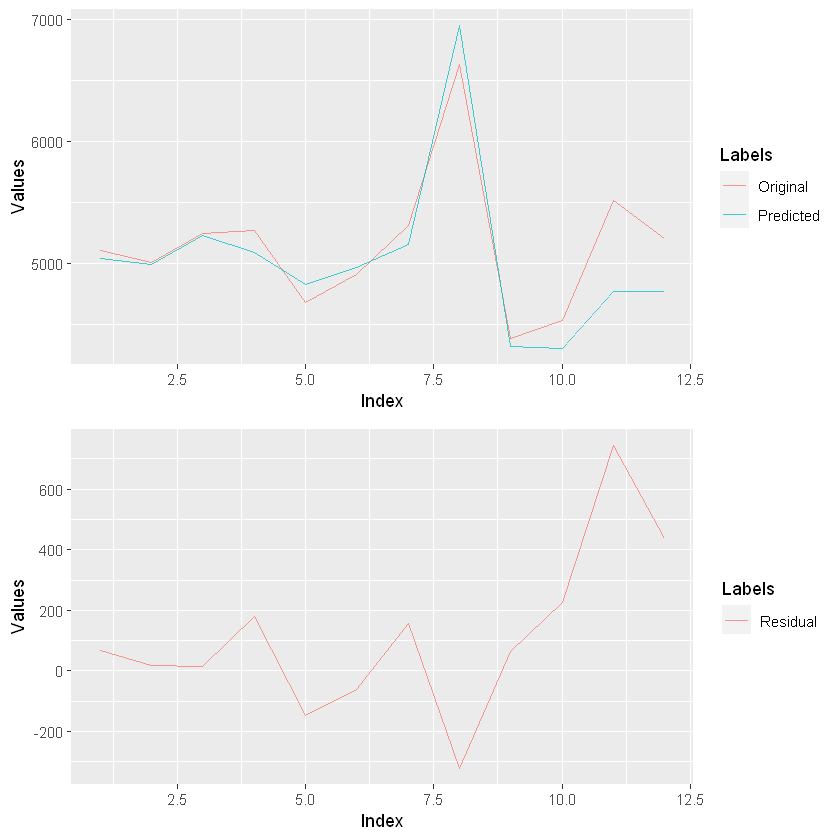

In [55]:
tser.my.plot(model.ts.test, ets.forecast$mean, component.labs = c("Predicted"))

В этом методе предсказания больше точек дальше от реального значения. Это касается и точек не из $2020$ года.

In [56]:
ets.mse <- mean((model.ts.test - ets.forecast$mean) ^ 2)
ets.mse

[1] 82677.24

Попробуем подавление тренда для предсказания.

In [57]:
ets.d <- ets(model.ts.train, ic = "aicc", opt.crit = "lik", damped = T)
ets.d

ETS(M,Ad,M) 

Call:
 ets(y = model.ts.train, damped = T, opt.crit = "lik", ic = "aicc") 

  Smoothing parameters:
    alpha = 0.2926 
    beta  = 0.0193 
    gamma = 2e-04 
    phi   = 0.9799 

  Initial states:
    l = 1808.9382 
    b = 0.2506 
    s = 1.3753 1.0223 0.9893 0.9606 1.0157 1.0495
           1.004 1.0162 0.9341 0.9347 0.8459 0.8522

  sigma:  0.0257

     AIC     AICc      BIC 
4728.704 4730.917 4796.978 

Заметим, что демпирующий параметр $\phi = 0.9799$, то есть подавление имеет значение. Для самого последнего предсказания мы получим коэффициент для тренда: $\sum\limits_{i=1}^{12}\phi^{i} \approx 10.54$, вместо $12$ для модели без демпирования. Сделаем предсказание:

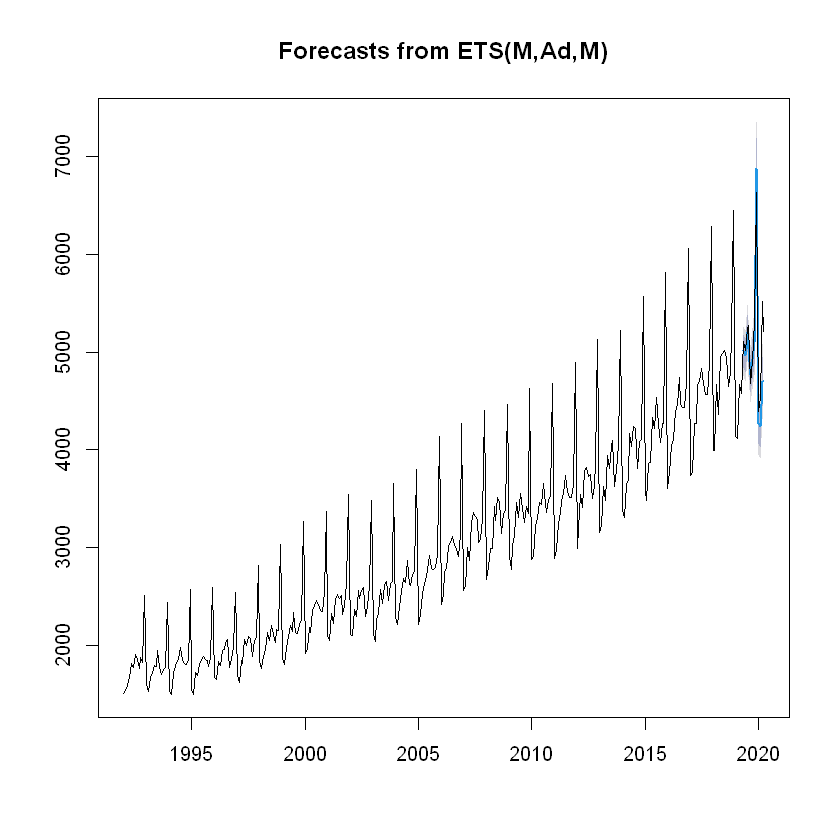

In [58]:
ets.d.forecast <- forecast(ets.d, h = 12)
plot(ets.d.forecast)
lines(data)


	Ljung-Box test

data:  Residuals from ETS(M,Ad,M)
Q* = 333.82, df = 7, p-value < 2.2e-16

Model df: 17.   Total lags used: 24



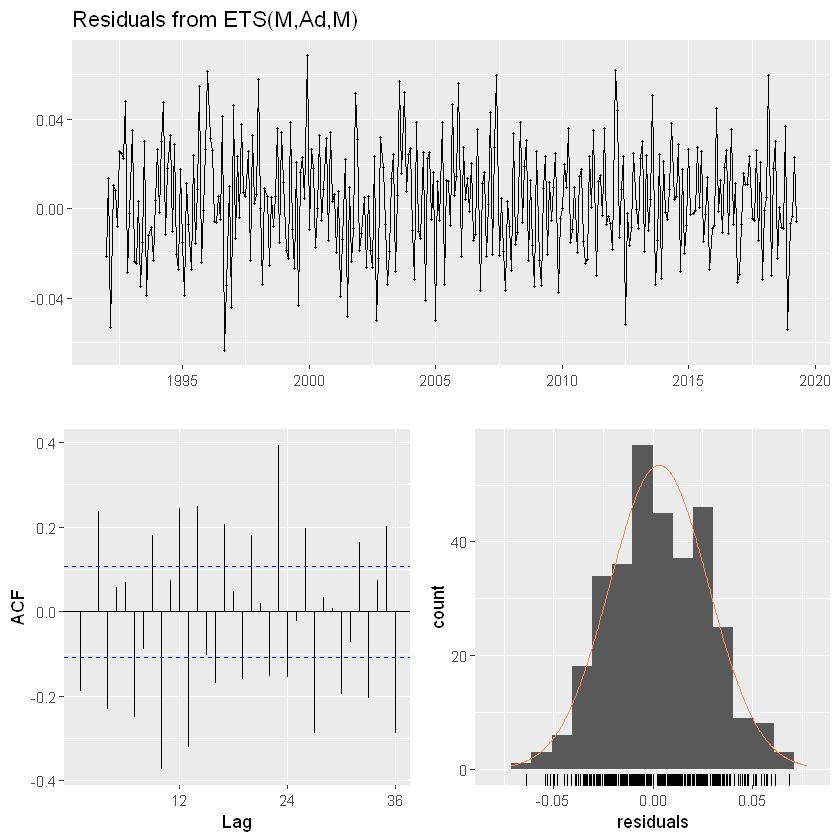

In [59]:
checkresiduals(ets.d)

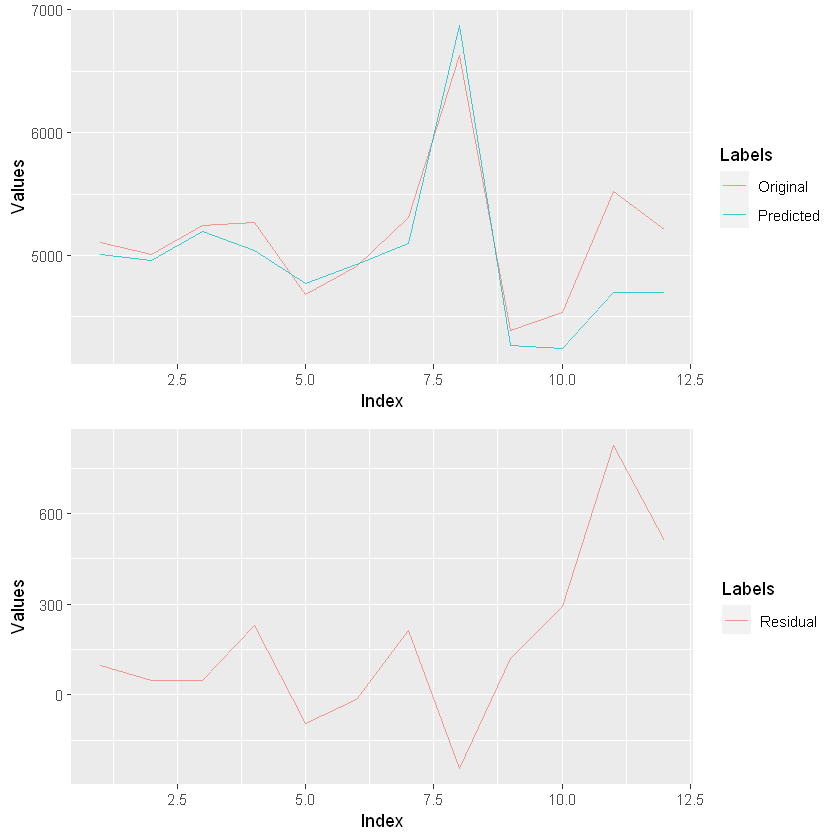

In [60]:
tser.my.plot(model.ts.test, ets.d.forecast$mean, component.labs = c("Predicted"))

In [61]:
ets.d.mse <- mean((model.ts.test - ets.d.forecast$mean)^2)
ets.d.mse

[1] 101811.6

Ошибка явно стала только больше...

# SSA

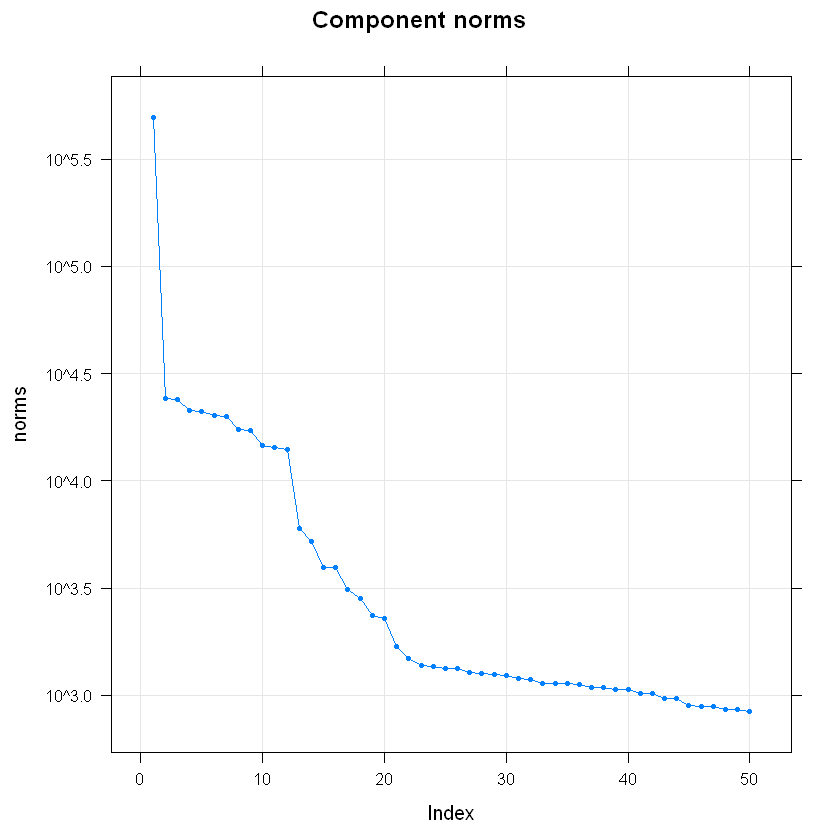

In [62]:
s <- ssa(model.ts.train)
plot(s)

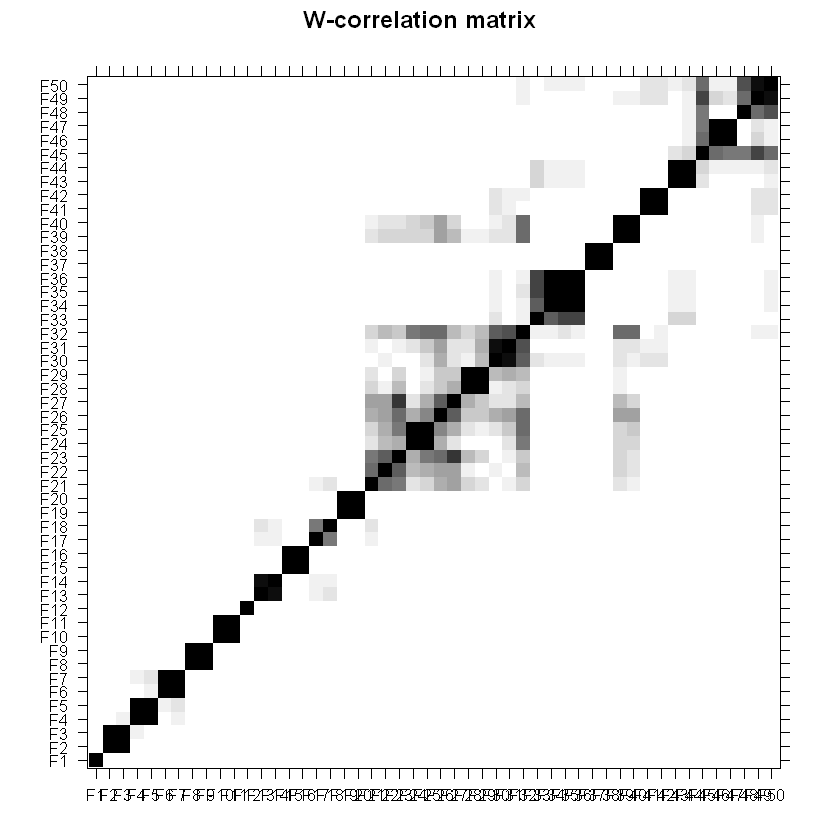

In [63]:
plot(s, type = 'wcor')

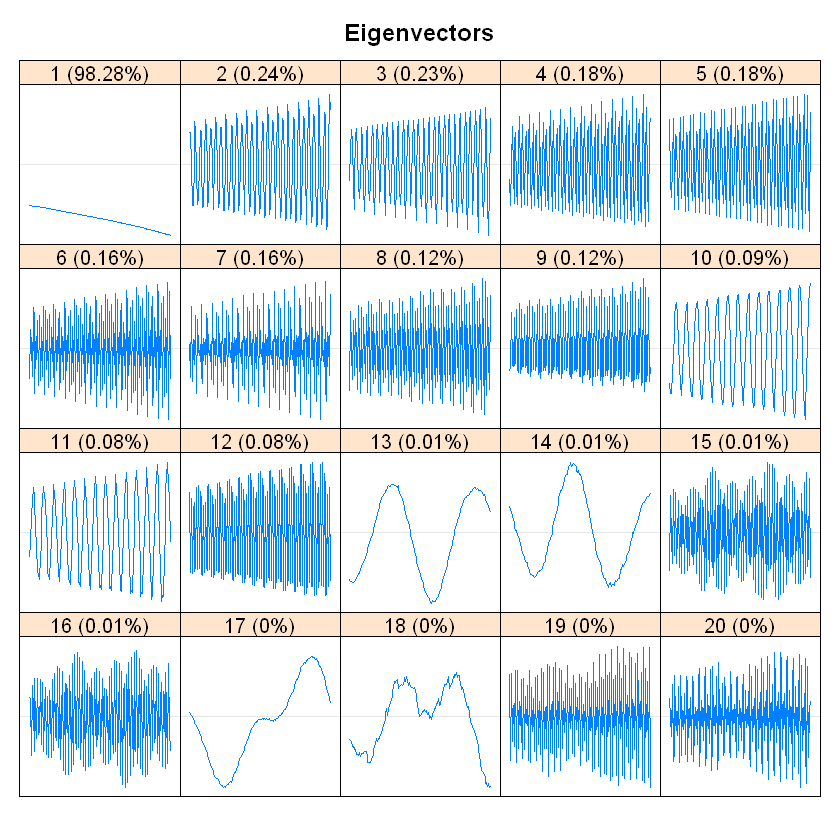

In [64]:
plot(s, type = 'vectors', idx = 1:20)

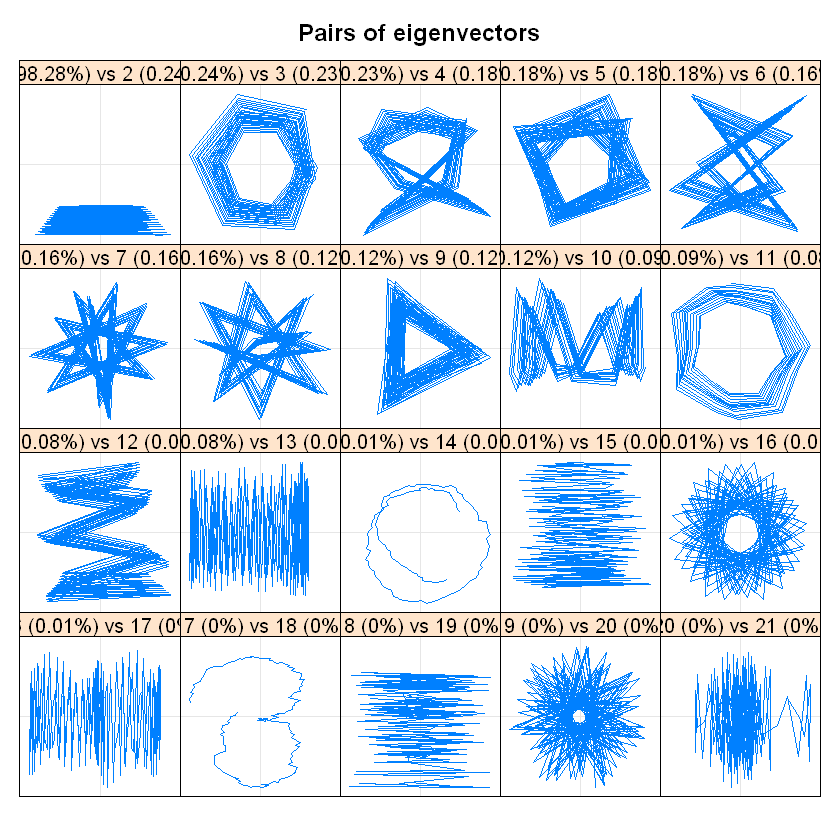

In [65]:
plot(s, type = "paired", idx = 1:20)

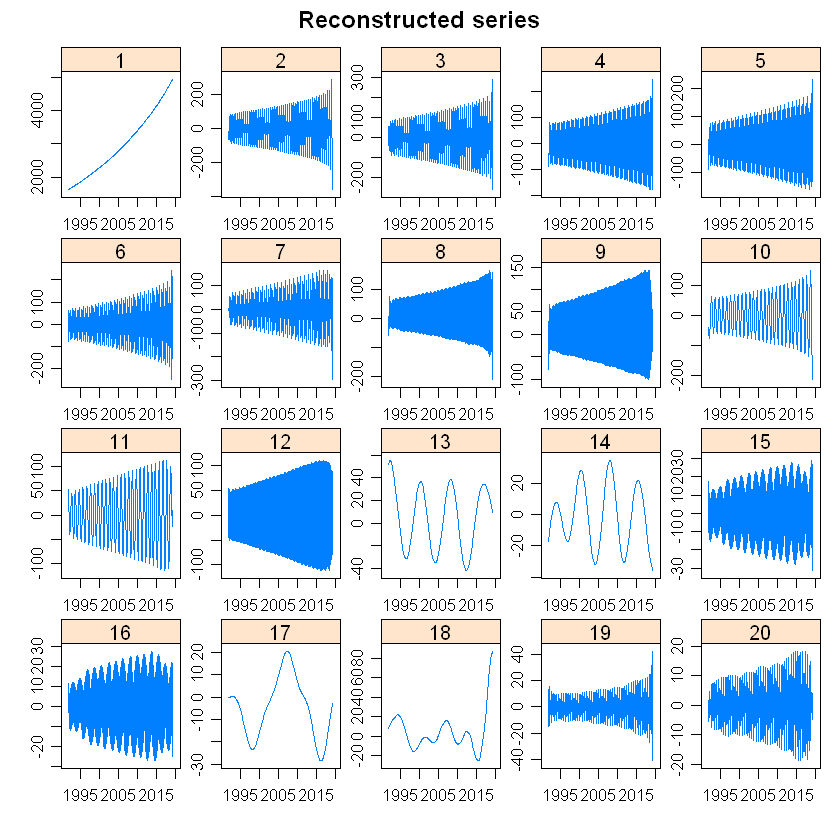

In [66]:
plot(s, type = 'series', groups = as.list(1:20))

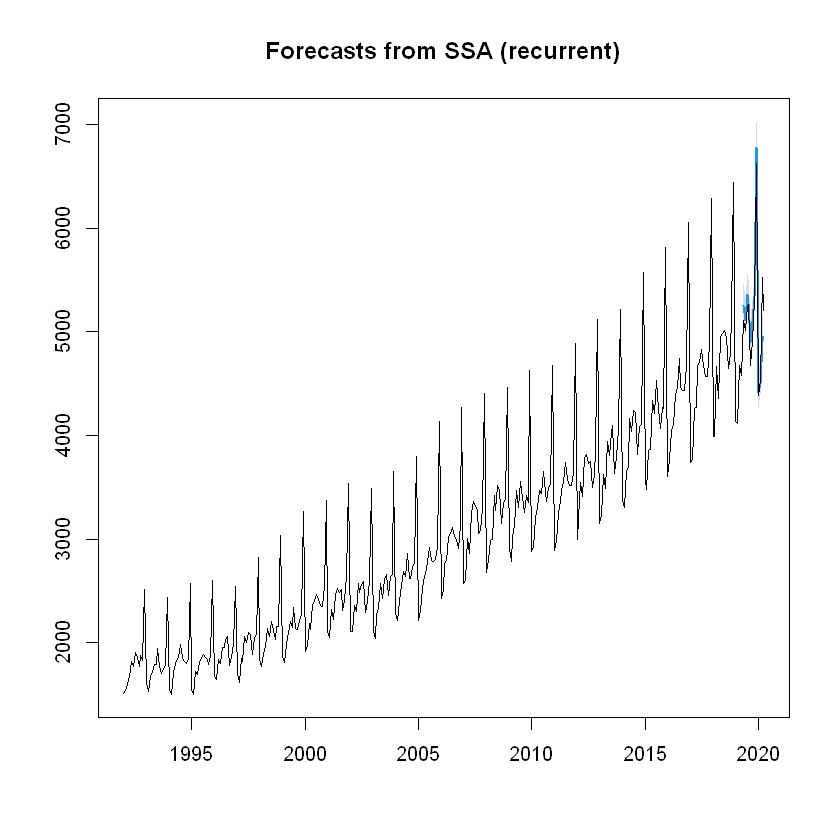

In [67]:
ssa.forecast <- forecast(s, groups = list(Signal = c(1:18)), len = 12,
                             method = "recurrent", interval = "prediction", only.intervals = T, level = 0.95)
plot(ssa.forecast)
lines(data)

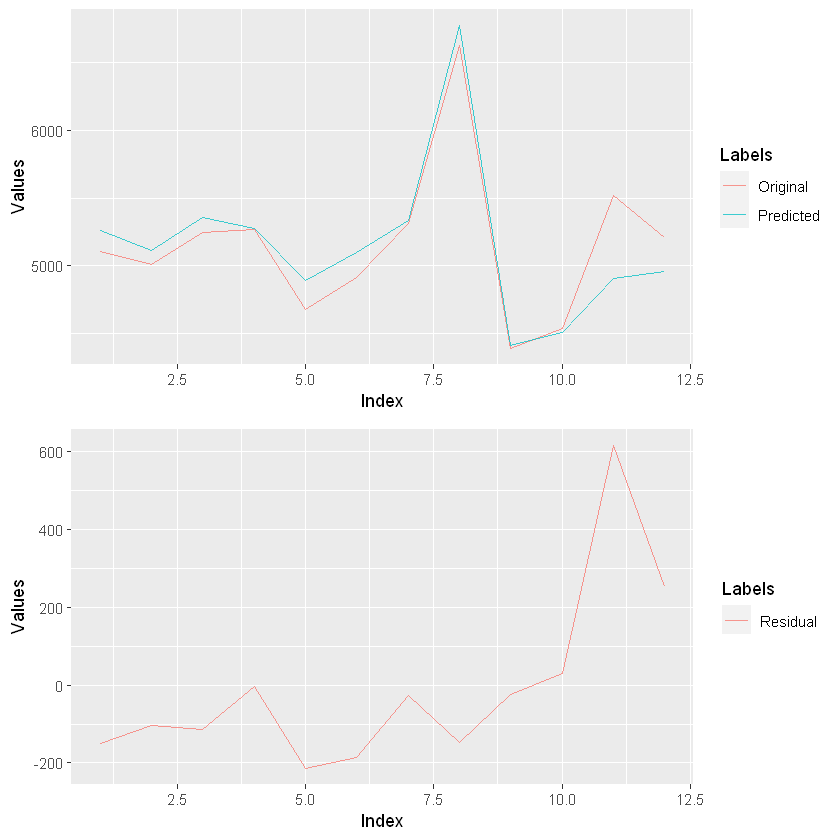

In [68]:
tser.my.plot(model.ts.test, ssa.forecast$mean, component.labs = c("Predicted"))

В отличие от предыдущих методов, здесь начало предсказания выглядит как будто чуть хуже, но зато с двумя точками из $2020$ года $SSA$ справился лучше. Может быть нам просто повезло. 

In [69]:
ssa.mse <- mean((ssa.forecast$mean - model.ts.test) ^ 2)
ssa.mse

[1] 49649.42

Отлично, получили наименьшую ошибку предсказания. 